In [72]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [73]:
from lib.optimizers import *
from lib.functions import *
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable

# A more complicated function

$$ M = 6, N = 9, F : \R^M \to \R^N$$

$$ F(x) = \begin{bmatrix}
    \sin(x_1) + \cos(2x_1) \\
    \cos(-2x_2 + 1) \\
    2 \exp((x_3 + 10) / ||x||_2) \\
    \exp(\sin(\pi/2 + ||x||_2)) \\
    \left(\ln\left(3 + \left|\sum_{i=1}^{M} x_i\right|\right) - 1\right)^2 \\
    \cos(\exp(\sin^2(x_5))) \\
    \left(\sin\left(\sqrt{|\sum_{i=1}^M x_i|} - 1\right)\right)^2 \\
    \sqrt{\sin(\prod_{i=1}^M x_i) + 2} \\
    \sqrt{|\cos(\exp(\sin(x_8)))|} \\
\end{bmatrix}$$

In [74]:
M = 6
sin = Function(F=np.sin, DF=np.cos, M=1, N=1)
cos = Function(F=np.cos, DF=lambda x: -np.sin(x), M=1, N=1)
exp = Function(F=np.exp, DF=np.exp, M=1, N=1)
log = Function(F=lambda x: np.log(np.abs(x)), DF=lambda x: 1 / x, M=1, N=1)
square = Function(F=lambda x: x**2, DF=lambda x: 2 * x, M=1, N=1)
abs = Function(F=np.abs, DF=lambda x: np.sign(x), M=1, N=1)
sqrt = Function(F=lambda x: np.sqrt(np.abs(x)), DF=lambda x: 0.5 / np.sqrt(np.abs(x)) * np.sign(x), M=1, N=1)
norm = Function(F=np.linalg.norm, DF=lambda x: x / np.linalg.norm(x), M=M, N=1)
sum_ = Function(F=np.sum, DF=lambda _: np.ones(M), M=M, N=1)
mul_ = Function(F=lambda x: np.array(np.prod(x)), DF=lambda x: np.prod(x) / x, M=M, N=1)
proj = lambda k: Function(F=lambda x: x[k], DF=lambda _: np.eye(M)[k], M=M, N=1)
constM = lambda c: Function(F=lambda _: np.array(c), DF=lambda _: np.zeros(M), M=M, N=1)
const1 = lambda c: Function(F=lambda _: np.array(c), DF=lambda _: np.zeros(1), M=1, N=1)
mul_const = lambda c: Function(F=lambda x: c * x, DF=lambda _: np.array(c), M=1, N=1)

F1 = compose(proj(0), sin + compose(mul_const(2), cos)) - constM(1)
F2 = compose(proj(1), mul_const(-2) + const1(1), cos) + constM(3)
F3 = compose((proj(2) + constM(10)) / norm, 2 * exp)
F4 = compose(norm + constM(np.pi / 2), sin, exp) - constM(10)
F5 = compose(compose(sum_, abs) + constM(3), log - const1(1), square)
F6 = compose(proj(4), sin, square, exp, cos)
F7 = compose(sum_, sqrt - const1(1), sin, square) + constM(1)
F8 = compose(mul_, sin + const1(2), sqrt)
F9 = compose(proj(5), sin, exp, cos, sqrt)
F = stack(F1, F2, F3, F4, F5, F6, F7, F8, F9)

# Performance tests

## Hyperparameters

In [75]:
np.random.seed(42)
p0 = np.random.randn(M)
max_iter = 1000
alpha_gn = 1e-2
max_iter_gd = 10000
alpha_gd = 1e-8
p0

array([ 0.49671415, -0.1382643 ,  0.64768854,  1.52302986, -0.23415337,
       -0.23413696])

## Gradient descent method

In [76]:
p, err = gradient_descent(F, p0, alpha_gd, max_iter_gd)
print(f"{p=}\n{err=}")

p=array([ 0.94611901, -0.26415628,  0.75721919,  2.90129523, -0.44616929,
       -0.44608302])
err=57.560053583595376


## Gauss-Newton method

In [77]:
p, err = gauss_newton(R=F, p0=p0, max_iter=max_iter, alpha=alpha_gn, step_type="cholesky")
print(f"{p=}\n{err=}")

p=array([-0.08291403, -0.90753174, -4.97858727,  3.19892127,  2.53369496,
        0.46853842])
err=8.921613782304398


In [78]:
p, err = gauss_newton(R=F, p0=p0, max_iter=max_iter, alpha=alpha_gn, step_type="least_squares")
print(f"{p=}\n{err=}")

p=array([-0.08291401, -0.90753176, -4.97858734,  3.19892025,  2.53369614,
        0.46853842])
err=8.921613780854221


## Levenberg-Marquardt method

#### 1. Constant $\lambda_k$ sequence

In [79]:
lambda_param = 1e-1
optimizer = LevenbergMarquardt(
    R=F, lambda_param_fun=LevenbergMarquardt.LambdaParamConstant(lambda0=lambda_param)
)

In [80]:
p, err = optimizer.optimize(p0, max_iter, step_type="cholesky")
print(f"{p=}\n{err=}")

p=array([-9.52484892e-03,  4.05930013e+01, -1.73610239e+01, -1.52828256e+01,
        4.72196096e+00, -3.61013108e+00])
err=10.82172788504922


In [81]:
p, err = optimizer.optimize(p0, max_iter, step_type="least_squares")
print(f"{p=}\n{err=}")

p=array([ 7.33200938e+01,  6.68630467e+01, -1.19785971e+02,  9.51185095e-02,
       -1.18273423e+01, -5.81464689e+00])
err=9.607836781775667


In [82]:
p, err = optimizer.optimize(p0, max_iter, step_type="cgnr", step_max_iter=10, step_tol=1e-6)
print(f"{p=}\n{err=}")

p=array([ 6.64131069e+01, -9.61477692e+00, -1.44950398e+02, -3.81975182e-05,
       -2.17782250e+00,  8.57678926e+01])
err=9.271713991165878


In [83]:
p, err = optimizer.optimize(p0, max_iter, step_type="svd")
print(f"{p=}\n{err=}")

p=array([ 1.04299291e-02,  1.22508879e+02, -6.56292055e+01, -4.50331597e+01,
       -8.88661135e+00,  2.67305423e+00])
err=10.33329628114937


#### 2. Sequence $\lambda_k$ decrasing when error is decreasing, and increasing otherwise

In [84]:
optimizer = LevenbergMarquardt(
    R=F,
    lambda_param_fun=LevenbergMarquardt.LambdaParamDefaultModifier(lambda0=1., lambda_change=1.1),
)

In [85]:
p, err = optimizer.optimize(p0, max_iter, step_type="cholesky")
print(f"{p=}\n{err=}")

p=array([ 0.85460032, -0.97471857, -5.84292383,  2.34251517, -0.24785578,
        0.49694986])
err=8.748400162540603


In [86]:
p, err = optimizer.optimize(p0, max_iter, step_type="least_squares")
print(f"{p=}\n{err=}")

p=array([ 0.85460032, -0.97471857, -5.84292381,  2.34251524, -0.24785579,
        0.49694983])
err=8.748400162540603


In [87]:
p, err = optimizer.optimize(p0, max_iter, step_type="cgnr", step_max_iter=10, step_tol=1e-16)
print(f"{p=}\n{err=}")

p=array([ 0.85460032, -0.97471857, -5.84292382,  2.34251522, -0.24785579,
        0.49694984])
err=8.748400162540603


In [88]:
p, err = optimizer.optimize(p0, max_iter, step_type="svd")
print(f"{p=}\n{err=}")

p=array([ 0.85460032, -0.97471857, -5.84292378,  2.34251531, -0.2478558 ,
        0.49694981])
err=8.748400162540603


#### Helper functions

In [89]:
_infty = 1e16
_zero = 1e-32

def remove_nans_infs_and_zeros(arr):
    arr = np.array(arr)
    arr[np.isnan(arr)] = _infty
    arr[np.isinf(arr)] = _infty
    arr[arr > _infty] = _infty
    arr[arr == 0] = _zero
    arr[arr < _zero] = _zero
    return arr

## Test CGNR parameters

In [90]:
step_tols = [float(10**i) for i in range(-16, 5)]
np.random.seed(42)
p0s = [2**i * np.random.randn(M) for i in range(5)]
max_iter = 100
step_max_iter = 100
lambda0 = 1.

errors_levenberg_marquardt_const_param = []
errors_levenberg_marquardt_modifying_param = []

for i, step_tol in enumerate(step_tols):
    print(f"step_tol: {step_tol} ({i + 1}/{len(step_tols)})")
    optimizer = LevenbergMarquardt(
        R=F, lambda_param_fun=LevenbergMarquardt.LambdaParamConstant(lambda0=lambda0)
    )

    errs = []
    for p0 in p0s:
        p, err = optimizer.optimize(p0, max_iter, step_type="cgnr", step_max_iter=step_max_iter, step_tol=step_tol)
        errs.append(err)
    errors_levenberg_marquardt_const_param.append(errs)

    optimizer = LevenbergMarquardt(
        R=F, lambda_param_fun=LevenbergMarquardt.LambdaParamDefaultModifier(lambda0=lambda0, lambda_change=2)
    )

    errs = []
    for p0 in p0s:
        p, err = optimizer.optimize(p0, max_iter, step_type="cgnr", step_max_iter=step_max_iter, step_tol=step_tol)
        errs.append(err)
    errors_levenberg_marquardt_modifying_param.append(errs)

step_tol: 1e-16 (1/21)
step_tol: 1e-15 (2/21)
step_tol: 1e-14 (3/21)
step_tol: 1e-13 (4/21)
step_tol: 1e-12 (5/21)
step_tol: 1e-11 (6/21)
step_tol: 1e-10 (7/21)
step_tol: 1e-09 (8/21)
step_tol: 1e-08 (9/21)
step_tol: 1e-07 (10/21)
step_tol: 1e-06 (11/21)
step_tol: 1e-05 (12/21)
step_tol: 0.0001 (13/21)
step_tol: 0.001 (14/21)
step_tol: 0.01 (15/21)
step_tol: 0.1 (16/21)
step_tol: 1.0 (17/21)
step_tol: 10.0 (18/21)
step_tol: 100.0 (19/21)
step_tol: 1000.0 (20/21)
step_tol: 10000.0 (21/21)


In [91]:
errors_mean_lm_const = np.mean(errors_levenberg_marquardt_const_param, axis=1)
errors_mean_lm_const = remove_nans_infs_and_zeros(errors_mean_lm_const)

errors_mean_lm_mod = np.mean(errors_levenberg_marquardt_modifying_param, axis=1)
errors_mean_lm_mod = remove_nans_infs_and_zeros(errors_mean_lm_mod)

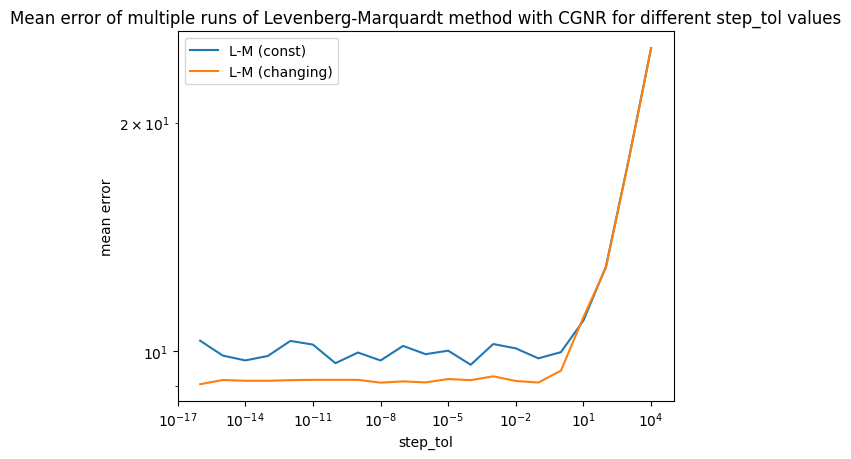

In [92]:
plt.loglog(step_tols, errors_mean_lm_const, label="L-M (const)")
plt.loglog(step_tols, errors_mean_lm_mod, label="L-M (changing)")

plt.legend()
plt.xlabel("step_tol")
plt.ylabel("mean error")
plt.title("Mean error of multiple runs of Levenberg-Marquardt method with CGNR for different step_tol values")
plt.show()

In [93]:
step_tol = 1e-8
np.random.seed(42)
p0s = [2**i * np.random.randn(M) for i in range(5)]
max_iter = 100
step_max_iters = [2**i for i in range(10)]

errors_levenberg_marquardt_const_param = []
errors_levenberg_marquardt_modifying_param = []

for i, step_max_iter in enumerate(step_max_iters):
    print(f"step_max_iter: {step_max_iter} ({i + 1}/{len(step_max_iters)})")
    optimizer = LevenbergMarquardt(
        R=F, lambda_param_fun=LevenbergMarquardt.LambdaParamConstant(lambda0=lambda0)
    )

    errs = []
    for p0 in p0s:
        p, err = optimizer.optimize(p0, max_iter, step_type="cgnr", step_max_iter=step_max_iter, step_tol=step_tol)
        errs.append(err)
    errors_levenberg_marquardt_const_param.append(errs)

    optimizer = LevenbergMarquardt(
        R=F, lambda_param_fun=LevenbergMarquardt.LambdaParamDefaultModifier(lambda0=lambda0, lambda_change=2)
    )

    errs = []
    for p0 in p0s:
        p, err = optimizer.optimize(p0, max_iter, step_type="cgnr", step_max_iter=step_max_iter, step_tol=step_tol)
        errs.append(err)
    errors_levenberg_marquardt_modifying_param.append(errs)

step_max_iter: 1 (1/10)
step_max_iter: 2 (2/10)
step_max_iter: 4 (3/10)
step_max_iter: 8 (4/10)
step_max_iter: 16 (5/10)
step_max_iter: 32 (6/10)
step_max_iter: 64 (7/10)
step_max_iter: 128 (8/10)
step_max_iter: 256 (9/10)
step_max_iter: 512 (10/10)


In [94]:
errors_mean_lm_const = np.mean(errors_levenberg_marquardt_const_param, axis=1)
errors_mean_lm_const = remove_nans_infs_and_zeros(errors_mean_lm_const)

errors_mean_lm_mod = np.mean(errors_levenberg_marquardt_modifying_param, axis=1)
errors_mean_lm_mod = remove_nans_infs_and_zeros(errors_mean_lm_mod)

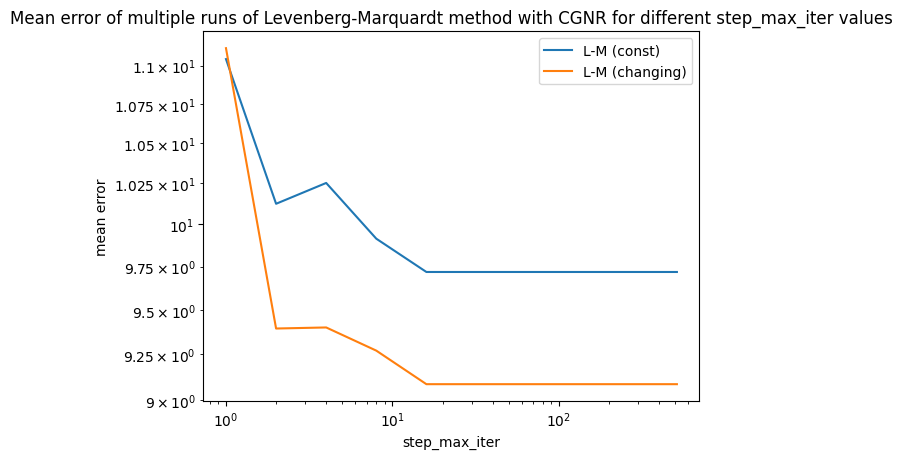

In [95]:
plt.loglog(step_max_iters, errors_mean_lm_const, label="L-M (const)")
plt.loglog(step_max_iters, errors_mean_lm_mod, label="L-M (changing)")

plt.legend()
plt.xlabel("step_max_iter")
plt.ylabel("mean error")
plt.title("Mean error of multiple runs of Levenberg-Marquardt method with CGNR for different step_max_iter values")
plt.show()

## Test lambda/alpha parameters

In [96]:
lambda_params = [float(10**i) for i in range(-16, 3)]
np.random.seed(42)
p0s = [2**i * np.random.randn(M) for i in range(5)]
max_iter = 100
max_iter_gd = 1000
step_max_iter = 100
step_tol = 100

errors_levenberg_marquardt_const_param = []
errors_levenberg_marquardt_modifying_param = []
errors_gauss_newton = []
errors_gradient_descent = []

for i, lambda_param in enumerate(lambda_params):
    print(f"lambda/alpha param: {lambda_param} ({i + 1}/{len(lambda_params)})")
    optimizer = LevenbergMarquardt(
        R=F, lambda_param_fun=LevenbergMarquardt.LambdaParamConstant(lambda0=lambda_param)
    )

    errs = []
    for p0 in p0s:
        p, err = optimizer.optimize(p0, max_iter, step_type="cgnr", step_max_iter=step_max_iter, step_tol=step_tol)
        errs.append(err)
    errors_levenberg_marquardt_const_param.append(errs)

    optimizer = LevenbergMarquardt(
        R=F, lambda_param_fun=LevenbergMarquardt.LambdaParamDefaultModifier(lambda0=lambda_param, lambda_change=2)
    )

    errs = []
    for p0 in p0s:
        p, err = optimizer.optimize(p0, max_iter, step_type="cgnr", step_max_iter=step_max_iter, step_tol=step_tol)
        errs.append(err)
    errors_levenberg_marquardt_modifying_param.append(errs)

    errs = []
    for p0 in p0s:
        p, err = gauss_newton(R=F, p0=p0, alpha=lambda_param, max_iter=max_iter)
        errs.append(err)
    errors_gauss_newton.append(errs)

    errs = []
    for p0 in p0s:
        p, err = gradient_descent(R=F, p0=p0, alpha=lambda_param, max_iter=max_iter_gd)
        errs.append(err)
    errors_gradient_descent.append(errs)

lambda/alpha param: 1e-16 (1/19)
lambda/alpha param: 1e-15 (2/19)
lambda/alpha param: 1e-14 (3/19)
lambda/alpha param: 1e-13 (4/19)
lambda/alpha param: 1e-12 (5/19)
lambda/alpha param: 1e-11 (6/19)
lambda/alpha param: 1e-10 (7/19)
lambda/alpha param: 1e-09 (8/19)
lambda/alpha param: 1e-08 (9/19)
lambda/alpha param: 1e-07 (10/19)
lambda/alpha param: 1e-06 (11/19)
lambda/alpha param: 1e-05 (12/19)
lambda/alpha param: 0.0001 (13/19)


c:\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\matip\Documents\UW\ml-numerki\project\lib\functions.py:44: RuntimeWarning: invalid value encountered in sin
  return self.F(x)
c:\Users\matip\Documents\UW\ml-numerki\project\lib\functions.py:31: RuntimeWarning: invalid value encountered in cos
  DF = lambda x: DF_old(x).reshape(1, M)


lambda/alpha param: 0.001 (14/19)


c:\Users\matip\Documents\UW\ml-numerki\project\lib\functions.py:170: RuntimeWarning: invalid value encountered in multiply
  return (f.differential(x) * g(x) - f(x) * g.differential(x)) / (g(x)**2)
c:\Users\matip\Documents\UW\ml-numerki\project\lib\functions.py:170: RuntimeWarning: invalid value encountered in divide
  return (f.differential(x) * g(x) - f(x) * g.differential(x)) / (g(x)**2)


lambda/alpha param: 0.01 (15/19)
lambda/alpha param: 0.1 (16/19)
lambda/alpha param: 1.0 (17/19)
lambda/alpha param: 10.0 (18/19)
lambda/alpha param: 100.0 (19/19)


In [97]:
errors_mean_lm_const = np.mean(errors_levenberg_marquardt_const_param, axis=1)
errors_mean_lm_const = remove_nans_infs_and_zeros(errors_mean_lm_const)

errors_mean_lm_mod = np.mean(errors_levenberg_marquardt_modifying_param, axis=1)
errors_mean_lm_mod = remove_nans_infs_and_zeros(errors_mean_lm_mod)

errors_gn_mean = np.mean(errors_gauss_newton, axis=1)
errors_gn_mean = remove_nans_infs_and_zeros(errors_gn_mean)

errors_gd_mean = np.mean(errors_gradient_descent, axis=1)
errors_gd_mean = remove_nans_infs_and_zeros(errors_gd_mean)

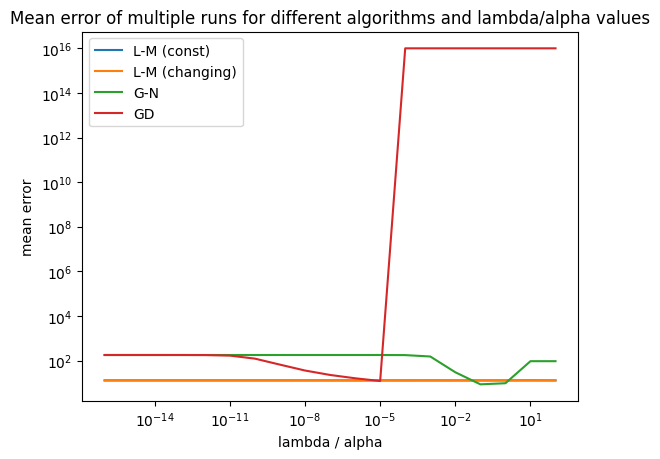

In [98]:
plt.loglog(lambda_params, errors_mean_lm_const, label="L-M (const)")
plt.loglog(lambda_params, errors_mean_lm_mod, label="L-M (changing)")
plt.loglog(lambda_params, errors_gn_mean, label="G-N")
plt.loglog(lambda_params, errors_gd_mean, label="GD")

plt.legend()
plt.xlabel("lambda / alpha")
plt.ylabel("mean error")
plt.title("Mean error of multiple runs for different algorithms and lambda/alpha values")
plt.show()

In [99]:
errors_min_lm_const = np.min(errors_levenberg_marquardt_const_param, axis=1)
errors_min_lm_const = remove_nans_infs_and_zeros(errors_min_lm_const)

errors_min_lm_mod = np.min(errors_levenberg_marquardt_modifying_param, axis=1)
errors_min_lm_mod = remove_nans_infs_and_zeros(errors_min_lm_mod)

errors_gn_min = np.min(errors_gauss_newton, axis=1)
errors_gn_min = remove_nans_infs_and_zeros(errors_gn_min)

errors_gd_min = np.min(errors_gradient_descent, axis=1)
errors_gd_min = remove_nans_infs_and_zeros(errors_gd_min)

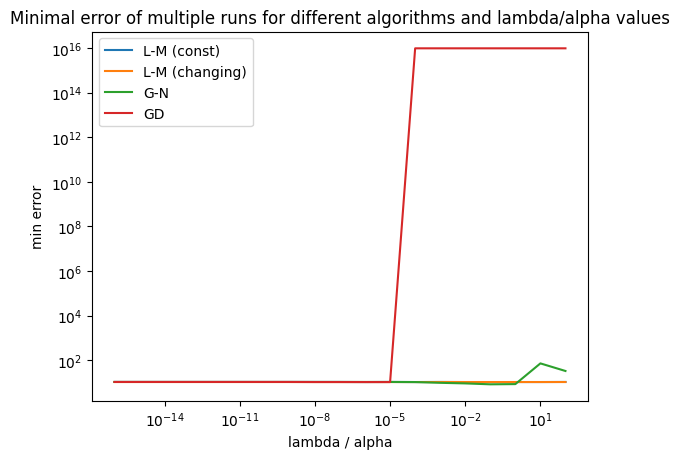

In [100]:
plt.loglog(lambda_params, errors_min_lm_const, label="L-M (const)")
plt.loglog(lambda_params, errors_min_lm_mod, label="L-M (changing)")
plt.loglog(lambda_params, errors_gn_min, label="G-N")
plt.loglog(lambda_params, errors_gd_min, label="GD")

plt.legend()
plt.xlabel("lambda / alpha")
plt.ylabel("min error")
plt.title("Minimal error of multiple runs for different algorithms and lambda/alpha values")
plt.show()

## Test number of iterations

In [101]:
max_iters = [2**i for i in range(0, 12)]
np.random.seed(42)
p0s = [2**i * np.random.randn(M) for i in range(5)]
alpha_gd = 1e-8
alpha_gn = 1e-3
lambda0 = 1.
lambda_change = 2.
step_max_iter = 100
step_tol = 100

errors_levenberg_marquardt_const_param = []
errors_levenberg_marquardt_modifying_param = []
errors_gauss_newton = []
errors_gradient_descent = []

for i, max_iter in enumerate(max_iters):
    print(f"max_iter: {max_iter} ({i + 1}/{len(max_iters)})")
    optimizer = LevenbergMarquardt(
        R=F, lambda_param_fun=LevenbergMarquardt.LambdaParamConstant(lambda0=lambda0)
    )

    errs = []
    for p0 in p0s:
        p, err = optimizer.optimize(p0, max_iter, step_type="cgnr", step_max_iter=step_max_iter, step_tol=step_tol)
        errs.append(err)
    errors_levenberg_marquardt_const_param.append(errs)

    optimizer = LevenbergMarquardt(
        R=F, lambda_param_fun=LevenbergMarquardt.LambdaParamDefaultModifier(lambda0=lambda0, lambda_change=lambda_change)
    )

    errs = []
    for p0 in p0s:
        p, err = optimizer.optimize(p0, max_iter, step_type="cgnr", step_max_iter=step_max_iter, step_tol=step_tol)
        errs.append(err)
    errors_levenberg_marquardt_modifying_param.append(errs)

    errs = []
    for p0 in p0s:
        p, err = gauss_newton(R=F, p0=p0, alpha=alpha_gn, max_iter=max_iter)
        errs.append(err)
    errors_gauss_newton.append(errs)

    errs = []
    for p0 in p0s:
        p, err = gradient_descent(R=F, p0=p0, alpha=alpha_gd, max_iter=max_iter)
        errs.append(err)
    errors_gradient_descent.append(errs)

max_iter: 1 (1/12)
max_iter: 2 (2/12)
max_iter: 4 (3/12)
max_iter: 8 (4/12)
max_iter: 16 (5/12)
max_iter: 32 (6/12)
max_iter: 64 (7/12)
max_iter: 128 (8/12)
max_iter: 256 (9/12)
max_iter: 512 (10/12)
max_iter: 1024 (11/12)
max_iter: 2048 (12/12)


In [102]:
errors_mean_lm_const = np.mean(errors_levenberg_marquardt_const_param, axis=1)
errors_mean_lm_const = remove_nans_infs_and_zeros(errors_mean_lm_const)

errors_mean_lm_mod = np.mean(errors_levenberg_marquardt_modifying_param, axis=1)
errors_mean_lm_mod = remove_nans_infs_and_zeros(errors_mean_lm_mod)

errors_gn_mean = np.mean(errors_gauss_newton, axis=1)
errors_gn_mean = remove_nans_infs_and_zeros(errors_gn_mean)

errors_gd_mean = np.mean(errors_gradient_descent, axis=1)
errors_gd_mean = remove_nans_infs_and_zeros(errors_gd_mean)

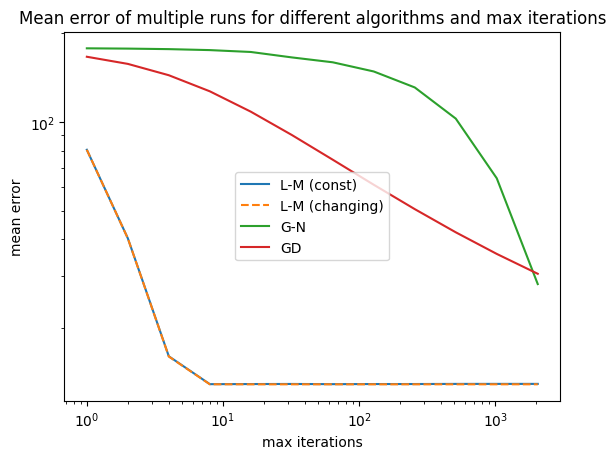

In [103]:
plt.loglog(max_iters, errors_mean_lm_const, label="L-M (const)")
plt.loglog(max_iters, errors_mean_lm_mod, label="L-M (changing)", linestyle="--")
plt.loglog(max_iters, errors_gn_mean, label="G-N")
plt.loglog(max_iters, errors_gd_mean, label="GD")

plt.legend()
plt.xlabel("max iterations")
plt.ylabel("mean error")
plt.title("Mean error of multiple runs for different algorithms and max iterations")
plt.show()

In [104]:
errors_min_lm_const = np.min(errors_levenberg_marquardt_const_param, axis=1)
errors_min_lm_const = remove_nans_infs_and_zeros(errors_min_lm_const)

errors_min_lm_mod = np.min(errors_levenberg_marquardt_modifying_param, axis=1)
errors_min_lm_mod = remove_nans_infs_and_zeros(errors_min_lm_mod)

errors_gn_min = np.min(errors_gauss_newton, axis=1)
errors_gn_min = remove_nans_infs_and_zeros(errors_gn_min)

errors_gd_min = np.min(errors_gradient_descent, axis=1)
errors_gd_min = remove_nans_infs_and_zeros(errors_gd_min)

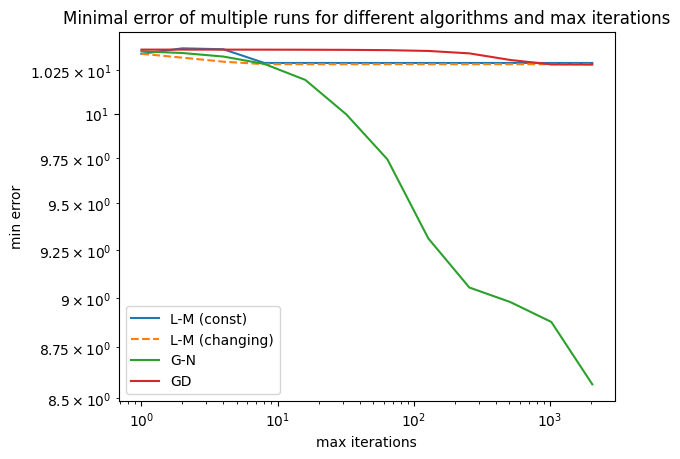

In [105]:
plt.loglog(max_iters, errors_min_lm_const, label="L-M (const)")
plt.loglog(max_iters, errors_min_lm_mod, label="L-M (changing)", linestyle="--")
plt.loglog(max_iters, errors_gn_min, label="G-N")
plt.loglog(max_iters, errors_gd_min, label="GD")

plt.legend()
plt.xlabel("max iterations")
plt.ylabel("min error")
plt.title("Minimal error of multiple runs for different algorithms and max iterations")
plt.show()